# Data Exploration

## Loading Data

The data has been placed in a public S3 bucket for this tutorial. We will be using the data from Kaggle's [M5 Forecasting Accuracy](https://www.kaggle.com/competitions/m5-forecasting-accuracy) competition. This contains Walmart sales data for the USA.

We are working with **42,840 hierarchical time series**. The data were obtained in the 3 US states of California (CA), Texas (TX), and Wisconsin (WI). “Hierarchical” here means that data can be aggregated on different levels: item level, department level, product category level, and state level. The sales information reaches back from Jan 2011 to June 2016. In addition to the sales numbers, we are also given corresponding data on prices, promotions, and holidays. Note, that we have been warned that most of the time series contain zero values.

The data comprises 3049 individual products from 3 categories and 7 departments, sold in 10 stores in 3 states. The hierachical aggregation captures the combinations of these factors. For instance, we can create 1 time series for all sales, 3 time series for all sales per state, and so on. The largest category is sales of all individual 3049 products per 10 stores for 30490 time series.

We start by downloading and unzipping the contents. This will give us the CSV files to work with.

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import zipfile
import os

download_path = os.path.abspath(os.path.join(".","..","data","m5-forecasting-accuracy.zip"))
unzipped_path = os.path.abspath(os.path.join(".","..","data","m5-forecasting-accuracy-unzipped"))

s3 = boto3.client('s3', region_name='us-east-2', config=Config(signature_version=UNSIGNED))
s3.download_file('fugue-data', 'm5-forecasting-accuracy.zip', download_path)

with zipfile.ZipFile(download_path,"r") as zip_ref:
    zip_ref.extractall(unzipped_path)

os.remove(download_path)


## First Look at Data

We'll take a quick look at the data given to us to understand the problem more. Most of the code snippets here are taken from [Rob Mulla's Starter Notebook](https://www.kaggle.com/code/robikscube/m5-forecasting-starter-data-exploration). We're not going to go to deep to understand everything. We're only interested in setting up an end-to-end modelling pipeline.

In [2]:
import pandas as pd

# Read in the data
INPUT_DIR = unzipped_path
WORKING_DIR = os.path.join(unzipped_path, "..", "working")
calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
training_data = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv')
sell_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')


**Training Data**

We take a look at the head. Note the following:
1. There is a hierarchichal nature to the data. There is a `dept_id` and a `cat_id`. 
2. A `store_id` + `item_id` is a unique identifier
3. Columns `d_1` to `d_1913` form our timeseries of purchases

In [3]:
training_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


**Sell Prices**

In [4]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


**Calendar**

We need to join `training_data` with `calendar` data by `wm_yr_wk` we can map the prices to dates

In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## Initial Plots

We are not too concerned with getting the best model. We just want to understand the data better and what the timeseries looks like.

In [6]:
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle

plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

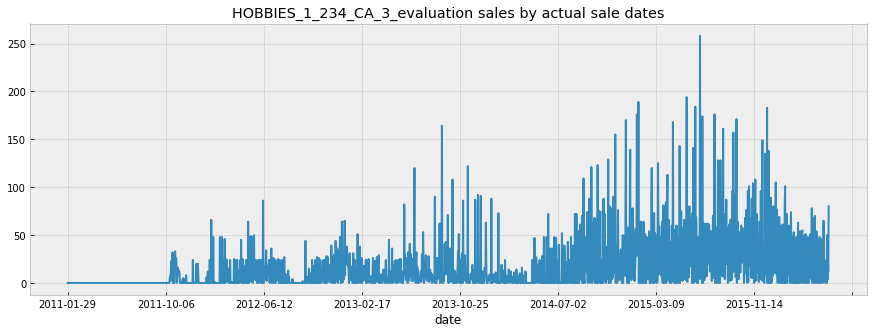

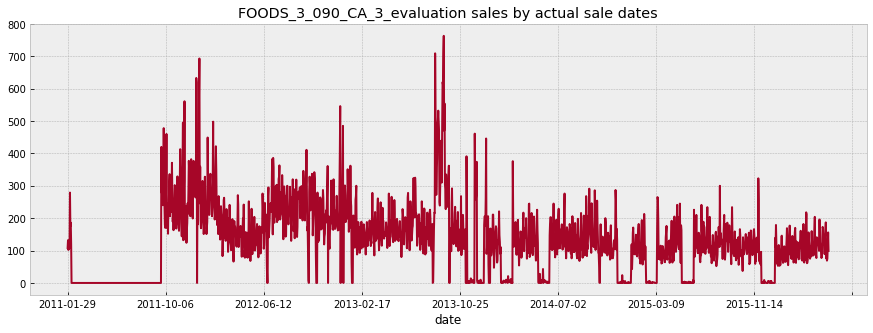

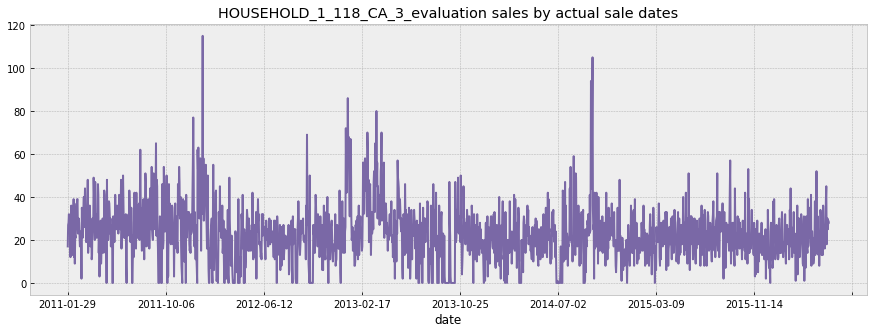

In [7]:
d_cols = [c for c in training_data.columns if 'd_' in c] # sales data columns

def plot_one(data: pd.DataFrame, calendar: pd.DataFrame, id: str) -> None:
    data = data.loc[data['id'] == id].copy(deep=True)
    idx = data.index.values[0]
    example = (
        data[d_cols]\
        .T\
        .rename(columns={str(idx):id})\
        .reset_index()\
        .rename(columns={'index': 'd'})\
        .merge(calendar, how='left', validate='one_to_one')\
        .set_index('date')[idx]
    )
    example.plot(figsize=(15, 5),
            color=next(color_cycle),
            title=f'{id} sales by actual sale dates')
    plt.show()
    return

plot_one(training_data, calendar, 'HOBBIES_1_234_CA_3_evaluation')
plot_one(training_data, calendar, 'FOODS_3_090_CA_3_evaluation')
plot_one(training_data, calendar, 'HOUSEHOLD_1_118_CA_3_evaluation')

## Next Steps

In this section, we took an initial look at the data. In the next section, we'll begin preprocessing it.